<h1> DS200A Computer Vision Assignment</h1>

Author: Junsheng Pei
        Nuocheng Lyu
        Zihao Yang

<h2>  Part Two: Feature Selection </h2>	


<h4> In this section, we would like you to select between 15 and 20 features to focus your model on. This will require significant explatoratory research. The first one is already implemented for you, and the next two are pre-specified.  </h4>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import skimage
from skimage import data
from skimage import io,img_as_ubyte
import os
from pathlib import Path
from sklearn.metrics.cluster import entropy
from skimage.morphology import disk
# please make sure you have installed opencv
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from  skimage import measure


In [2]:
# load the images 
data_file = Path("./", "image_data.hdf")
train_df = pd.read_hdf(data_file, "train")
test_df = pd.read_hdf(data_file, "test")

### Feature selection functions

In [3]:
# Returns the pixel size of the image
def size(image):
    return image.size

# Returns the average of the red-channel pictures for the images
def red_channel(image):
    return np.mean(image[:,:,0])

# Returns the average of the green-channel pictures for the images
def green_channel(image):
    return np.mean(image[:,:,1])

# Returns the average of the blue-channel pictures for the images
def blue_channel(image):
    return np.mean(image[:,:,2])

#Returns the aspect ratio of the image
def aspect_ratio(image):
    return image.shape[0] / image.shape[1]

#return the entropy of the gray-color matrix, the brighter the color is, the larger the entropy is
def entropy_gray(image):
    grayImg = skimage.color.rgb2gray(image)
    return entropy(grayImg)

#return the entropy of the endges with connerHarris Algorithm
#the larger the entropy is, the simpler the shaple is
def entropy_edge_Harris(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    dst = cv2.cornerHarris(gray,4,17,0.2)
    return entropy(dst>0.0005*dst.max())

#return the entropy of the endges with goodFeaturesToTrack Algorithm with limited numbers and minimum distance
#the larger the entropy is, the simpler the shaple is
def entropy_edge_goodFeature(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray,200,0.01,10)
    corners = np.int0(corners)
    return entropy(corners)    



In [4]:
def hu_moments(image):
    # Transefer the image into a gray one
    im_new = skimage.color.rgb2gray(image)
            
    # Calculate the Hu invariant moments of the image
    M = measure.moments(im_new)
    cr = M[1, 0] / M[0, 0]
    cc = M[0, 1] / M[0, 0]
    central = measure.moments_central(im_new, (cr, cc))
    norm = measure.moments_normalized(central)
    hu = measure.moments_hu(norm)
    
    return hu

def color_moments(image):
    im_hsv = skimage.color.rgb2hsv(image)
    h, s, v = im_hsv[:, :, 0], im_hsv[:, :, 1], im_hsv[:, :, 2]

    color_feature = []
    # N = h.shape[0] * h.shape[1]
    # The first central moment - average 
    h_mean = np.mean(h)  # np.sum(h)/float(N)
    s_mean = np.mean(s)  # np.sum(s)/float(N)
    v_mean = np.mean(v)  # np.sum(v)/float(N)
    color_feature.extend([h_mean, s_mean, v_mean])
    # The second central moment - standard deviation
    h_std = np.std(h)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    s_std = np.std(s)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    v_std = np.std(v)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    color_feature.extend([h_std, s_std, v_std])
    # The third central moment - the third root of the skewness
    h_skewness = np.mean(abs(h - h.mean())**3)
    s_skewness = np.mean(abs(s - s.mean())**3)
    v_skewness = np.mean(abs(v - v.mean())**3)
    h_thirdMoment = h_skewness**(1./3)
    s_thirdMoment = s_skewness**(1./3)
    v_thirdMoment = v_skewness**(1./3)
    color_feature.extend([h_thirdMoment, s_thirdMoment, v_thirdMoment])
    # Returns the average of the red-channel pictures for the images
    
    return color_feature
#Returns the aspect ratio of the image

In [5]:
#entropy of the greyscale histogram of the picuture
def his_entrogy(data, b=255):
    hist1 = np.histogram(data, bins=b, density=True)
    data = hist1[0]
    ent = np.log(np.abs(data))
    ent[(ent == -np.inf) | (ent == np.inf)] = 0
    ent = -(data * ent).sum()
    return ent

#standard deviation of the greyscale histogram of the picuture
def his_std(data, b=255):
    hist1 = np.histogram(data, bins=b, density=True)
    data = hist1[0]
    ret = np.std(np.abs(data))
    return ret

#plot histogram
def his(data, b=255):
    hist = np.histogram(data, bins=b, density=True)
    return hist[0]

#plot and visualize the histogram of the picture(std, entropy, histogram equalization)
def histogram_visualization(ori_pic, bins=255):
    print("")
    print("------------------------------------------------------------------------------")
    print("|                              histogram_visualization                        |")
    print("------------------------------------------------------------------------------")
    io.imshow(ori_pic)
    pic_grey = skimage.color.rgb2gray(ori_pic)

    plt.figure(figsize=(15, 4))
    plt.subplot(131)
    plt.title("histogram greyscale")
    pic_grey_his = pic_grey.flatten()
    plt.hist(pic_grey_his, bins=256, normed=1,edgecolor='None',facecolor='red') #原始图像直方图

    # histogram of rgb
    plt.subplot(132)
    plt.title("histogram rgb")
    pic_r = ori_pic[:,:,0]
    pic_g = ori_pic[:,:,1]
    pic_b = ori_pic[:,:,2]
    pic_r_his= pic_r.flatten()
    plt.hist(pic_r_his, bins=256, normed=1,facecolor='r',edgecolor='r',hold=1)
    pic_r_his= pic_g.flatten()
    plt.hist(pic_r_his, bins=256, normed=1, facecolor='g',edgecolor='g',hold=1)
    pic_r_his= pic_b.flatten()
    plt.hist(pic_r_his, bins=256, normed=1, facecolor='b',edgecolor='b')

    # histogram of equalization
    plt.subplot(133)
    plt.title("histogram equalization")
    pic_grey_his_eq = skimage.exposure.equalize_hist(pic_grey)
    pic_grey_his_eq = pic_grey_his_eq.flatten()
    plt.hist(pic_grey_his_eq, bins=256, normed=1, facecolor='b',edgecolor='b')
    plt.show()

    print("his_entropy:", his_entrogy((255 * pic_grey).flatten(), bins))
    print("his_entropy_with_eq:", his_entrogy((255 * pic_grey_his_eq).flatten(), bins))
    print("his_std:", his_std((255 * pic_grey).flatten(), bins))
    print("his_std_with_eq:", his_std((255 * pic_grey_his_eq).flatten(), bins))

Define more features above, performing any EDA research below. We expect all external sources sited, and a couple significant different graphs indicating some form of EDA. 

<h2> Graphs </h2>

#### Feature 1-3: mean of colors

We chose the mean of the three color channels as three features. The three feature helps us differentiate the
pictures by the foremost color.

The foremost color in a picture of dolphi is (172, 191, 205 ) which is close to blue and gray


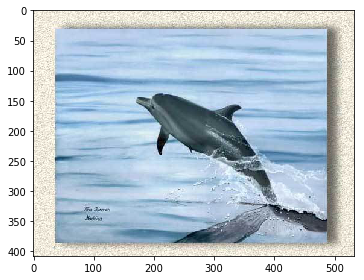

In [17]:
dolphin_color = train_df['pictures'][456]
io.imshow(dolphin_color)
red = int(np.mean(dolphin_color[:,:,0]))
green = int(np.mean(dolphin_color[:,:,1]))
blue = int(np.mean(dolphin_color[:,:,2]))
print(f'The foremost color in a picture of dolphin is\
 ({str(red)}, {str(green)}, {str(blue)} ) which is close to blue and gray' )

In [20]:
train_df['label'][40]

9

The foremost color in a picture of gorilla is (87, 77, 58) which is close to brown


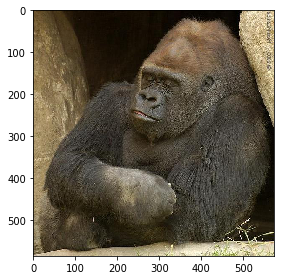

In [24]:
gorilla_color= train_df['pictures'][40]
io.imshow(gorilla_color)
red = int(np.mean(gorilla_color[:,:,0]))
green = int(np.mean(gorilla_color[:,:,1]))
blue = int(np.mean(gorilla_color[:,:,2]))
print(f'The foremost color in a picture of gorilla is ({str(red)}, {str(green)}, {str(blue)}) \
which is close to brown' )

#### Feature 4-5: Image Size and aspect_ratio

#### Feature 6: Entropy of color

The entropy of color matrix reflects how brightful the images are.

In [56]:
plane = train_df['pictures'][300]
plane_color_entropy = entropy(gorilla)
print(f'The entropy of color matrix for a picture of plane is {str(plane_color_entropy)}, \
which is smaller, because the color of plane is lighter' )
crab = train_df['pictures'][142]
crab_color_entropy = entropy(crab)
print(f'The entropy of color matrix for a picture of a crab is {str(crab_color_entropy)}, \
which is larger, because the color of crab is brighter' )

The entropy of color matrix for a picture of plane is 4.791763445543888, which is smaller, because the color of plane is lighter
The entropy of color matrix for a picture of a crab is 5.375296499216458, which is larger, because the color of crab is brighter


#### Feature 7-8: Entropy of contour

We use two functions from opencv, one is cv2.cornerHarris and the other is cv2.goodFeaturesToTrack to find the
contour of the items in the images

The entropy of the plane is 10.034812448993613


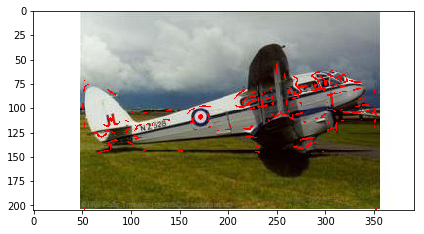

In [154]:
plane = train_df['pictures'][313].copy()
gray = cv2.cvtColor(plane,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,3,19,0.1)
dst>0.0005*dst.max()

# # Threshold for an optimal value, it may vary depending on the image.
plane[dst>0.0005*dst.max()]=[255,0,0]
io.imshow(plane)
plane_entropy = entropy(dst)
print(f'The entropy of the plane is {plane_entropy}, which is smaller, because the shape of airplne is simpler')

The entropy of the dog is 11.463954653287288, which is larger, because the shape of a dog is more complex


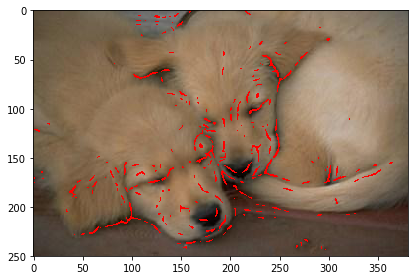

In [155]:
dog = train_df['pictures'][345].copy()
gray = cv2.cvtColor(dog,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,3,19,0.1)
dst>0.0005*dst.max()

# # Threshold for an optimal value, it may vary depending on the image.
dog[dst>0.0005*dst.max()]=[255,0,0]
io.imshow(dog)
dog_entropy = entropy(dst)
print(f'The entropy of the dog is {dog_entropy}, which is larger, because the shape of a dog is more complex')

cv2.goodFeaturesToTrack also finds the contours, but it can limit the numbers and the minimum distances for 
the contours, so we can avoid finding two many points in a certain areas like the fur of animals.

limited contour points for the same pictures


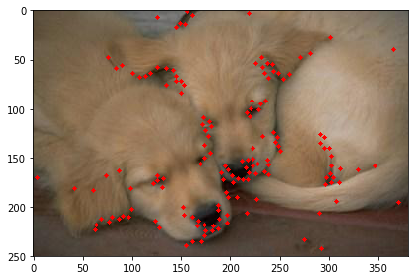

In [49]:
dog_limited_edges = train_df['pictures'][345].copy()
gray = cv2.cvtColor(dog_limited_edges,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,150,0.01,5)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(dog_limited_edges,(x,y),2,255,-1)
io.imshow(dog_limited_edges)  
print('limited contour points for the same pictures')

#### Feature 9-10: Entropy and STD of histogram


------------------------------------------------------------------------------
|                              histogram_visualization                        |
------------------------------------------------------------------------------


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:3131: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


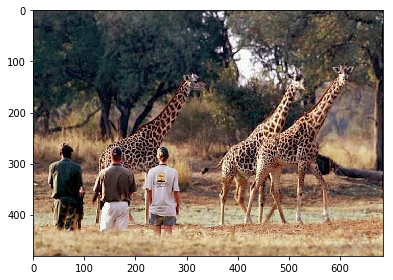

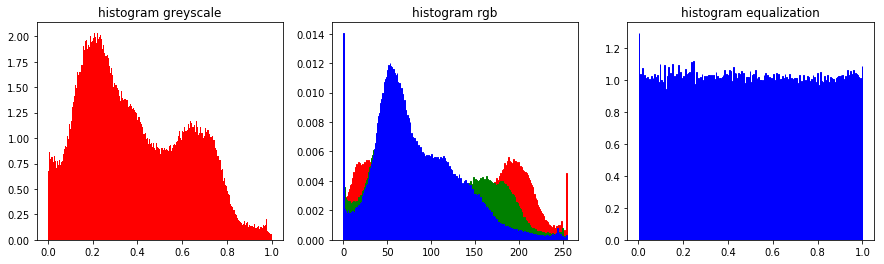

his_entropy: 5.37392185793758
his_entropy_with_eq: 5.552097757368828
his_std: 0.00209588596963338
his_std_with_eq: 0.00018680390555273673

------------------------------------------------------------------------------
|                              histogram_visualization                        |
------------------------------------------------------------------------------


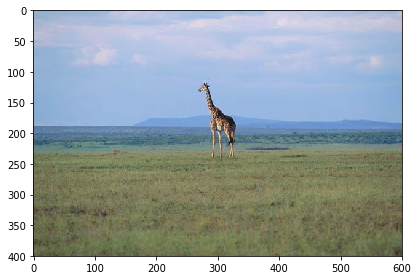

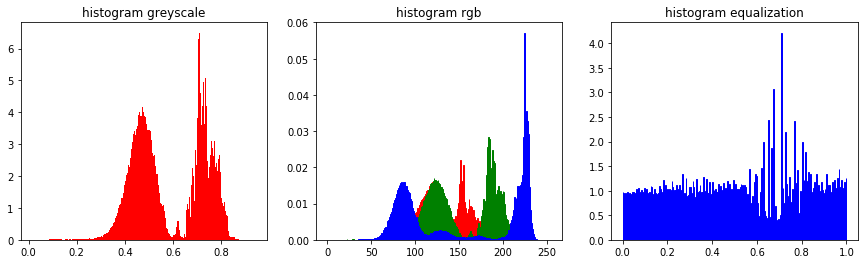

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


his_entropy: 4.968546021629665
his_entropy_with_eq: 5.478470148896592
his_std: 0.005732777487918531
his_std_with_eq: 0.0015250100980278964

------------------------------------------------------------------------------
|                              histogram_visualization                        |
------------------------------------------------------------------------------


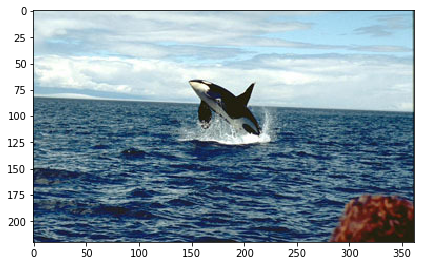

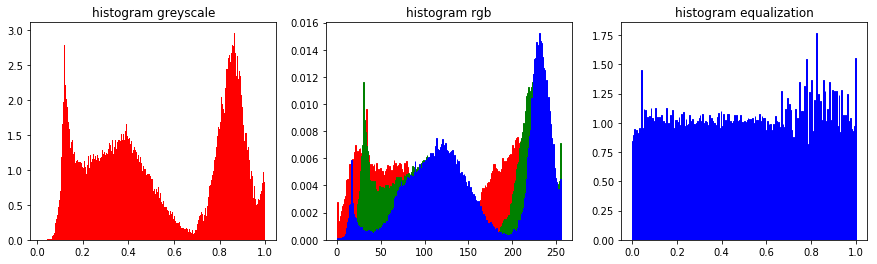

his_entropy: 5.377380684771884
his_entropy_with_eq: 5.530124048607
his_std: 0.002668476801483805
his_std_with_eq: 0.000590329620191962


In [29]:
histogram_visualization(ori_pic = train_df['pictures'][507])
histogram_visualization(ori_pic = train_df['pictures'][500])
histogram_visualization(ori_pic = train_df['pictures'][600])

#### Feature 11-13: Hu's moment invariants

In [39]:
def centroid(image):
    # Transefer the image into a gray one
    im_new = skimage.color.rgb2gray(image)
            
    # Calculate the x, y components of the centroid
    M = measure.moments(im_new)
    cr = M[1, 0] / M[0, 0]
    cc = M[0, 1] / M[0, 0]
    
    return [cr, cc]

#### All the Hu's invariants are calculated based on the centroid as well as the relative positions

The centroid of the image:


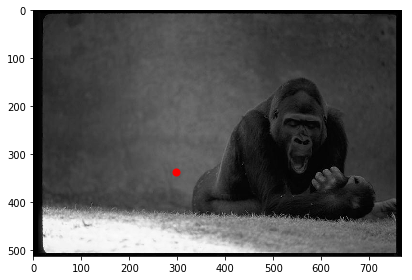

In [40]:
image = train_df['pictures'][3]
im_new = skimage.color.rgb2gray(image)
            
io.imshow(im_new)
[cr, cc] = centroid(im_new)
plt.scatter(cr, cc, c = 'r', s = 50)
print('The centroid of the image:')

#### Feature 14-15: color moments(variance of hue and saturation)

The raw image:


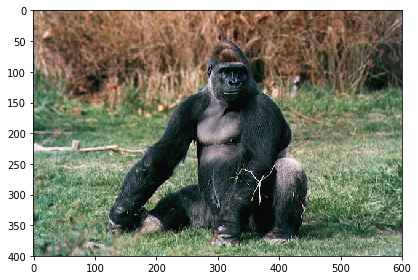

In [20]:
image = train_df['pictures'][119]
io.imshow(image)
print("The raw image:")

/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


Image presented in HSV channels:


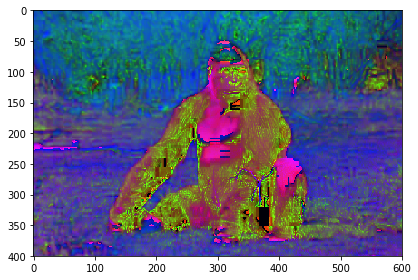

In [23]:
image_hsv = skimage.color.rgb2hsv(image)
# io.imshow(image)
io.imshow(image_hsv)
print('Image presented in HSV channels:')

#### We calculate the mean, variance and skewness of Hue, Saturation and Value of each image

Visualization of the separate hue, saturation and value channels:


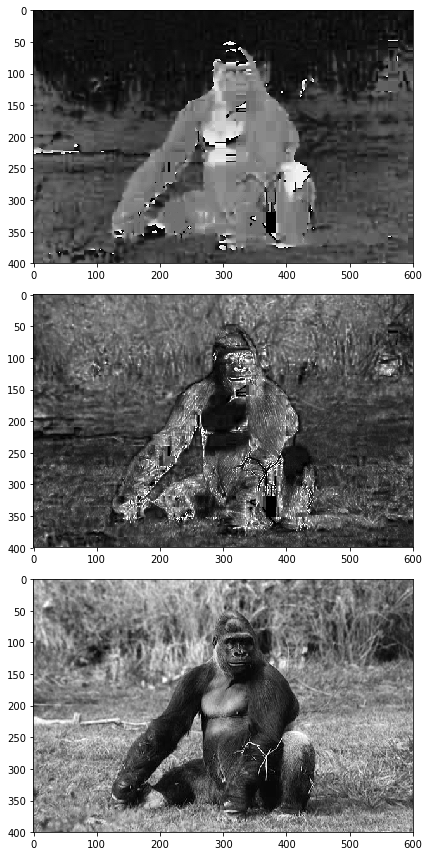

In [38]:
image_h = image_hsv[:,:,0]
image_s = image_hsv[:,:,1]
image_v = image_hsv[:,:,2]

plt.figure(figsize = (8, 12))

plt.subplot(3,1,1)
io.imshow(image_h)

plt.subplot(3,1,2)
io.imshow(image_s)

plt.subplot(3,1,3)
io.imshow(image_v)
print('Visualization of the separate hue, saturation and value channels:')

<h2> Sources </h2>

cv2.cornerHarris  from   https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html#harris-corners

cv2.goodFeaturesToTrack  from  https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html#shi-tomasi

entropy from  https://scikit-learn.org/stable/modules/clustering.html



<h2> DataFrame Creation </h2>

In [6]:

def feature_frame(df):
# ****************
    feature_matrix = pd.DataFrame()
    # size of the picture
    feature_matrix['size'] = df['pictures'].apply(lambda x : size(x) )
    # mean value for green channel
    feature_matrix['green_channel'] = df['pictures'].apply(lambda x : green_channel(x) )
    # mean value for blue channel
    feature_matrix['blue_channel'] = df['pictures'].apply(lambda x : blue_channel(x) )
    # mean value for red channel
    feature_matrix['red_channel'] = df['pictures'].apply(lambda x : red_channel(x) )
    # length / width of the image
    feature_matrix['aspect_ratio'] = df['pictures'].apply(lambda x : aspect_ratio(x) )
    # the entropy of grayscale image
    feature_matrix['entropy_gray'] = df['pictures'].apply(lambda x : entropy_gray(x) )
    # the entropy of the outlier of the image
    feature_matrix['entropy_edge_Harris'] = df['pictures'].apply(lambda x : entropy_edge_Harris(x))
    feature_matrix['entropy_edge_goodFeature'] = df['pictures'].apply(lambda x : entropy_edge_goodFeature(x))
    # convert the rgb picture to greyscale image for next step
    feature_matrix['grey'] = df['pictures'].apply(lambda x: skimage.color.rgb2gray(x))
    # make histogram for the greyscale image
    bins = 2
    feature_matrix['his'] = feature_matrix['grey'].apply(lambda x: his(x, bins))
    # the entropy, std of the histogram
    feature_matrix['his_ent_grey'] = feature_matrix['grey'].apply(lambda x: his_entrogy((255 * x).flatten(), bins))
    feature_matrix['his_std_grey'] = feature_matrix['grey'].apply(lambda x: his_std((255 * x).flatten(), bins)) 
    feature_matrix = feature_matrix.drop(columns=['grey',  'his'])
    
    # compute the moment invariants and color moments
    df['moment_invariants'] =  df['pictures'].apply(lambda x : hu_moments(x))
    df['color_moments'] =  df['pictures'].apply(lambda x : color_moments(x))
    # the 1st absolute invariant in Hu's moments
    feature_matrix['absolute_invariant_1'] =  df['moment_invariants'].apply(lambda x : x[0])
    # the 2nd absolute invariant in Hu's moments
    feature_matrix['absolute_invariant_2'] =  df['moment_invariants'].apply(lambda x : x[1])
    # the 6th absolute invariant in Hu's moments
    feature_matrix['absolute_invariant_6'] =  df['moment_invariants'].apply(lambda x : x[5])
    # the variance of hue
    feature_matrix['color_moment_h2'] =  df['color_moments'].apply(lambda x : x[3])
    # the variance of saturation
    feature_matrix['color_moment_s2'] =  df['color_moments'].apply(lambda x : x[4])
    
    #Returns data-frame with all the features now inside, and calculated
    return feature_matrix

In [7]:
# build the training feature matrix
feature_matrix_train = feature_frame(train_df)
feature_matrix_train['label'] = train_df['label']

In [8]:
# build the test feature matrix
feature_matrix_test = feature_frame(test_df)

In [9]:
# export the feature matrix
data_file = Path("./", "feature_matrix.hdf") # Path of hdf file
feature_matrix_train.to_hdf(data_file, "train") # Train data of hdf file
feature_matrix_test.to_hdf(data_file, "test") # Val data of hdf file

# KNN

In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression.In both cases, the input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression:

In k-NN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In k-NN regression, the output is the property value for the object. This value is the average of the values of its k nearest neighbors.